Tutorial:
https://www.kaggle.com/code/samuelcortinhas/spaceship-titanic-a-complete-guide

In [1]:
# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
import itertools
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import time

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils import resample

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
# Read dataset
data = pd.read_csv("data/train.csv")

In [3]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
print('Train set shape:', data.shape)

Train set shape: (8693, 14)


In [5]:
# Missing values
print('TRAIN SET MISSING VALUES:')
print(data.isna().sum())

TRAIN SET MISSING VALUES:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64


In [6]:
# Data types
data.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

Text(0.5, 1.0, 'Target distribution')

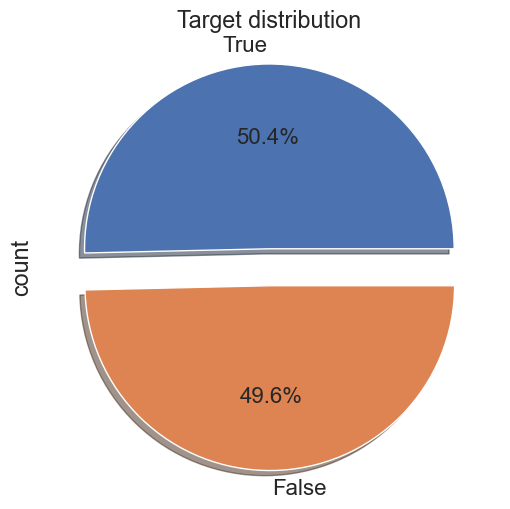

In [7]:
# Figure size
plt.figure(figsize=(6,6))

# Pie plot
data['Transported'].value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%', shadow=True, textprops={'fontsize':16}).set_title("Target distribution")

Text(0.5, 0, 'Age (years)')

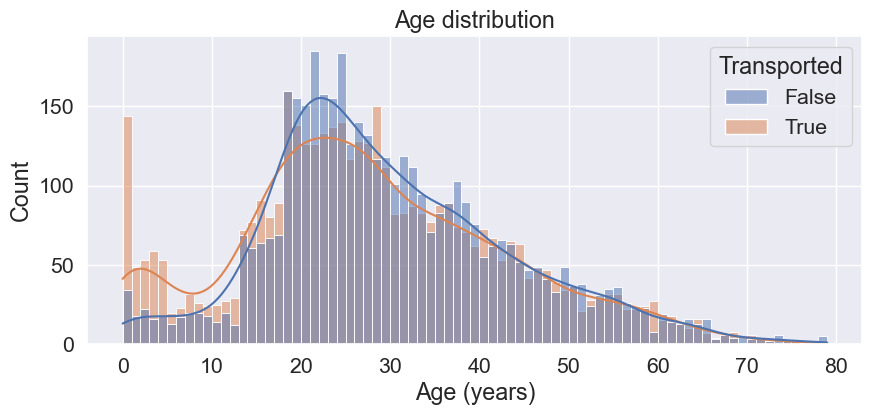

In [8]:
# Figure size
plt.figure(figsize=(10,4))

# Histogram
sns.histplot(data=data, x='Age', hue='Transported', binwidth=1, kde=True)

# Aesthetics
plt.title('Age distribution')
plt.xlabel('Age (years)')

In [9]:
# Columns with missing values
na_cols=data.columns[data.isna().any()].tolist()

# Missing values summary
mv=pd.DataFrame(data[na_cols].isna().sum(), columns=['Number_missing'])
mv['Percentage_missing']=np.round(100*mv['Number_missing']/len(data),2)
mv

,Number_missing,Percentage_missing
HomePlanet,201,2.31
CryoSleep,217,2.50
Cabin,199,2.29
Destination,182,2.09
Age,179,2.06
VIP,203,2.34
RoomService,181,2.08
FoodCourt,183,2.11
ShoppingMall,208,2.39
Spa,183,2.11


In [10]:
data.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [11]:
# GLOBAL VALUE FOR COLUMNS
CON = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
CAT = ["HomePlanet", "CryoSleep", "Destination", "VIP"]
TAR = ["Transported"]

In [12]:
# For continuous value we fill using median
for col in CON:
    data[col].fillna(data[col].median(), inplace=True)

In [13]:
# For target we transform into int
data[TAR] = data[TAR]*1

In [14]:
# For categorical value we encode
encode = pd.get_dummies(data[CAT])
X = data[CON].join(encode)
Y = data[TAR].values

In [15]:
# Scale for BCE Loss
mm = MinMaxScaler()
X = mm.fit_transform(X)

In [16]:
# Split
xtrain, xvalid, ytrain, yvalid = train_test_split(X, Y, test_size=0.3)

In [17]:
import torch
from torch.utils.data import Dataset

In [18]:
class SpaceshipDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [19]:
train_ds = SpaceshipDataset(xtrain, ytrain)
valid_ds = SpaceshipDataset(xvalid, yvalid)

In [49]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=True)

In [50]:
# Display one data
train_features, train_target = next(iter(train_dl))
print(f"Feature shape: {train_features.size()}")
print(f"Feature: {train_features}")
print(f"Labels shape: {train_target.size()}")
print(f"Labels: {train_target}")

Feature shape: torch.Size([32, 16])
Feature: tensor([[5.1899e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00],
        [6.5823e-01, 0.0000e+00, 2.7874e-02, 6.5384e-02, 0.0000e+00, 3.2955e-01,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [4.1772e-01, 3.0921e-02, 1.0633e-02, 0.0000e+00, 6.6048e-03, 5.2211e-02,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00],
        [2.6582e-01, 2.7919e-04, 1.0063e-04, 6.3426e-03, 7.5866e-04, 1.8315e-02,
         1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000

In [22]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [23]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [36]:
class SpaceshipNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(16, 30),
            nn.ReLU(),
            nn.Linear(30, 60),
            nn.ReLU(),
            nn.Linear(60, 1)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear_relu_stack(x)
        x = self.sigmoid(x)
        return x

In [37]:
ssmodel = SpaceshipNetwork().to(device)
print(ssmodel)

SpaceshipNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=16, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=60, bias=True)
    (3): ReLU()
    (4): Linear(in_features=60, out_features=1, bias=True)
  )
  (sigmoid): Sigmoid()
)


In [44]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [52]:
learning_rate = 1e-3
batch_size = 32

In [53]:
loss_fn = nn.functional.binary_cross_entropy
optimizer = torch.optim.SGD(ssmodel.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dl, ssmodel, loss_fn, optimizer)
    #test_loop(valid_dl, ssmodel, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.684331  [   32/ 6085]
loss: 0.685855  [ 3232/ 6085]
Epoch 2
-------------------------------
loss: 0.687409  [   32/ 6085]
loss: 0.682858  [ 3232/ 6085]
Epoch 3
-------------------------------
loss: 0.679086  [   32/ 6085]
loss: 0.686532  [ 3232/ 6085]
Epoch 4
-------------------------------
loss: 0.685297  [   32/ 6085]
loss: 0.685161  [ 3232/ 6085]
Epoch 5
-------------------------------
loss: 0.680125  [   32/ 6085]
loss: 0.680711  [ 3232/ 6085]
Epoch 6
-------------------------------
loss: 0.679843  [   32/ 6085]
loss: 0.678167  [ 3232/ 6085]
Epoch 7
-------------------------------
loss: 0.680420  [   32/ 6085]
loss: 0.684104  [ 3232/ 6085]
Epoch 8
-------------------------------
loss: 0.676385  [   32/ 6085]
loss: 0.680904  [ 3232/ 6085]
Epoch 9
-------------------------------
loss: 0.674827  [   32/ 6085]
loss: 0.679032  [ 3232/ 6085]
Epoch 10
-------------------------------
loss: 0.683194  [   32/ 6085]
loss: 0.677577  [ 3232/ 6085]